## UHI Final Project
### ECOSTRESS Data Download and Overview Product

### Author: Paula Pérez

In [8]:
# Import libraries and set wd
import pandas as pd
import geopandas as gpd
# import earthpy.mask as em
from glob import glob as glob
import json
import matplotlib.pyplot as plt
import requests
import os
import pathlib
import re
import xarray as xr
import rioxarray as rxr
import zipfile
import tarfile
# import time

from cryptography.fernet import Fernet
from shapely.geometry import box

working_dir = os.path.join(
    pathlib.Path.home(), "Documents", "earth-analytics", "data", "uhi")
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
os.chdir(working_dir)

# This will make rioxarray run faster
rioxarray_option = rxr.set_options(export_grid_mapping=False)

In [2]:
# Define boundary
dir_limits = "area_limits"
if not os.path.exists(dir_limits):
    os.makedirs(dir_limits)

fpath_limits = "City_of_Boulder_City_Limits.zip"

# Unzip boundary file
with zipfile.ZipFile(fpath_limits, 'r') as zip_ref:
    zip_ref.extractall(dir_limits)

# Save as GeoDataFrame
fpath_limits_shp = os.path.join(dir_limits, fpath_limits.replace("zip","shp"))
limits_gdf = gpd.read_file(fpath_limits_shp)

# Save envelope
envelope_gdf = (
    limits_gdf.unary_union
    .envelope)

envelope_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(envelope_gdf))

[Text(0.5, 1.0, 'Study Area and Envelope')]

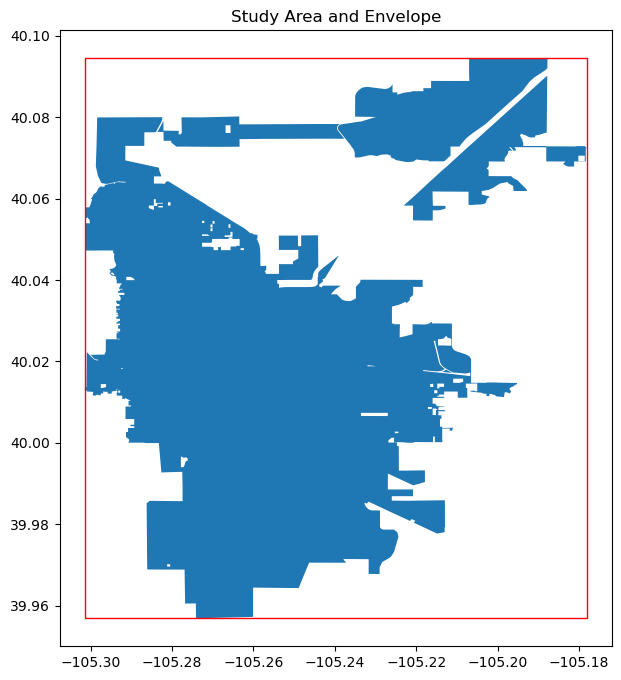

In [3]:
# Plot perimeter and envelope
fig, ax = plt.subplots(figsize=(12, 8))

limits_gdf.plot(ax=ax)
envelope_gdf.plot(facecolor='none', edgecolor='red', ax=ax)
ax.set(title='Study Area and Envelope')

In [4]:
# Download ECOSTRESS LST data using M2M API. First define useful classes:
class BBox:
    """
    A class for a bounding box based on the total bounds of a raster image

    Parameters
    ----------
    total_bounds : the total bounds property of a GeoDataFrame

    Returns
    -------
    spatial_filter : dict-like BBox object containing filterType,
    lowerLeft coordinates, and upperRight coordinates
    """

    def __init__(self, total_bounds):
        self.llx, self.lly, self.urx, self.ury = total_bounds

    @property
    def spatial_filter(self):
        return {
            'filterType': "mbr",
            'lowerLeft': {'latitude': self.lly, 'longitude': self.llx},
            'upperRight': {'latitude': self.ury, 'longitude': self.urx}}


class EarthExplorerDownloader:
    """
    A class to contain the download information and instructions for
    downloads from the EarthExplorer M2M API.

    Parameters
    ----------
    dataset : name (str) of the desired USGS dataset
    label : str used for dir and path names
    bbox : BBox object used for selecting scenes
    start, end : start and end dates to filter for

    Returns
    -------
    Upon initialising, carries out login and returns confirmation or error

    submit_download_request method returns dataset alias for download

    download method returns downloaded filenames and saves files
    to specified path
    """

    base_url = "https://m2m.cr.usgs.gov/api/api/json/stable/{endpoint}"
    product_filter = {
        'productName': 'C2 ARD Tile Surface Reflectance Bundle Download'}
    dld_file_tmpl = '{display_id}.tar'

    def __init__(self, dataset, label, bbox, start, end):
        self.api_key = None
        self.login()

        self.dataset, self.label = dataset, label
        self.bbox, self.start, self.end = bbox, start, end

        self.temporal_filter = {'start': start, 'end': end}
        self.acquisition_filter = self.temporal_filter

        self.path_tmpl = os.path.join(self.label, self.dld_file_tmpl)
        if not os.path.exists(label):
            os.makedirs(label)

        self._dataset_alias = None

    def get_ee_login_info(self, info_type):
        # Generate and store key

        # Encrypt
        key_path = os.path.join(pathlib.Path.home(), '.ee_key')
        if not os.path.exists(key_path):
            print('Generating new key...')
            key = Fernet.generate_key()
            with open(key_path, 'wb') as key_file:
                key_file.write(key)

        with open(key_path, 'rb') as key_file:
            key = key_file.read()
        fernet = Fernet(key)

        # Collect and store login info
        info_path = os.path.join(
            pathlib.Path.home(),
            '.ee_{}'.format(info_type))

        if not os.path.exists(info_path):
            info = input('Enter {}: '.format(info_type))
            with open(info_path, 'wb') as info_file:
                info_file.write(fernet.encrypt(bytes(info, 'utf-8')))

        with open(info_path, 'rb') as info_file:
            if len(info_file.read().decode('utf-8')) == 0:
                info = input('Enter {}: '.format(info_type))
                with open(info_path, 'wb') as info_file:
                    info_file.write(fernet.encrypt(bytes(info, 'utf-8')))

        # Decrypt for use
        with open(info_path, 'rb') as info_file:
            info_str = fernet.decrypt(info_file.read()).decode("utf-8")

        return info_str

    def login(self):
        # Submit (or collect) login information and obtain API key
        if self.api_key is None:
            login_payload = {
                'username': self.get_ee_login_info('username'),
                'password': self.get_ee_login_info('password')}
            self.api_key = self.post("login", login_payload)
            print('Login Successful')

    @property
    def headers(self):
        if self.api_key is None:
            return None
        return {'X-Auth-Token': self.api_key}

    def logout(self):
        self.post("logout", None)
        print("Logged Out\n\n")

    def post(self, endpoint, data):
        # Send POST requests
        url = self.base_url.format(endpoint=endpoint)
        response = requests.post(url, json.dumps(data), headers=self.headers)

        # Raise any HTTP Errors
        response.raise_for_status()

        # Return data
        return response.json()['data']

    @property
    def dataset_alias(self):
        # Retrieve dataset alias based on inputs
        if self._dataset_alias is None:
            print("Searching datasets...")
            params = {
                'datasetName': self.dataset,
                'spatialFilter': self.bbox.spatial_filter,
                'temporalFilter': self.temporal_filter}
            datasets = self.post("dataset-search", params)

            # Get a single dataset alias
            if len(datasets) > 1:
                print(datasets)
                raise ValueError('Multiple datasets found - refine search.')
            self._dataset_alias = datasets[0]['datasetAlias']

            print('Using dataset alias: {}'.format(self._dataset_alias))
        return self._dataset_alias

    def find_scene_ids(self):
        # Retrieve scene IDs based on input filters
        params = {
            'datasetName': self.dataset_alias,
            'startingNumber': 1,

            'sceneFilter': {
                'spatialFilter': self.bbox.spatial_filter,
                'acquisitionFilter': self.acquisition_filter}}

        print("Searching scenes...")
        scenes = self.post("scene-search", params)
        print('Found {} scenes'.format(scenes['recordsReturned']))
        return scenes

    def find_available_product_info(self):
        scenes = self.find_scene_ids()
        params = {
            'datasetName': self.dataset_alias,
            'entityIds': [scene['entityId'] for scene in scenes['results']]}
        products = self.post("download-options", params)

        # Aggregate a list of available products
        product_info = []
        for product in products:
            # Make sure the product is available for this scene
            if product['available'] is True or product['proxied'] is True:
                product_info.append({
                    'entityId': product['entityId'],
                    'productId': product['id']})
        if not product_info:
            raise ValueError('No available products.')
        return product_info

    def submit_download_request(self):
        product_info = self.find_available_product_info()
        # Did we find products?
        if product_info:
            # Request downloads
            params = {
                'downloads': product_info,
                'label': self.label}
            # downloads = self.post("download-request", params)
            self.post("download-request", params)
            print('Downloads staging...')
        else:
            raise ValueError(
                'No products found with the specified boundaries.')

    def check_download_status(self):
        params = {'label': self.label}
        downloads = self.post("download-retrieve", params)
        return downloads

    def wait_for_available_downloads(self, timeout=None):
        keep_waiting = True
        while keep_waiting:
            downloads = self.check_download_status()
            n_queued = downloads['queueSize']
            keep_waiting = n_queued > 0
            if keep_waiting:
                print("\n", n_queued,
                      "downloads queued but not yet available. "
                      "Waiting for 30 seconds.\n")
                time.sleep(30)

            if timeout is not None:
                timeout -= 30
                if timeout < 0:
                    break

        return downloads

    def download(self, wait=True, timeout=None, override=True):
        # Check download status
        if wait:
            downloads = self.wait_for_available_downloads(timeout=timeout)
        else:
            downloads = self.check_download_status()

        available_or_proxied = (
            downloads['available']
            + [dld for dld in downloads['requested']
               if dld['statusCode'] == 'P'])
        if not available_or_proxied:
            raise ValueError('No available downloads.')

        # Download available downloads
        for download in available_or_proxied:
            # Filter out products
            if self.product_filter is not None:
                match = [download[k] == v for k,
                         v in self.product_filter.items()]
                if not all(match):
                    continue

            # Download and save compressed file
            dld_path = self.path_tmpl.format(display_id=download['displayId'])
            # Cache downloads
            if override or not os.path.exists(dld_path):
                print('Saving download: {}'.format(download['displayId']))
                with open(dld_path, 'wb') as dld_file:
                    response = requests.get(download['url'])
                    dld_file.write(response.content)

            self.uncompress(dld_path)

    def uncompress(self, download_path):
        # Extract compressed files
        with tarfile.TarFile(download_path, 'r') as dld_tarfile:
            dld_tarfile.extractall(self.label)

In [5]:
# Download ECOSTRESS LST Data
bbox = BBox(limits_gdf.total_bounds)

ee_downloader = EarthExplorerDownloader(
    dataset="ECO2LSTE",
    # dataset="Landsat 4-9 C2 U.S. ARD",
    label="eco_lst_test",
    bbox=bbox,
    start="2021-01-01",
    end="2021-01-10")

Login Successful


In [7]:
# Submit download request
# ee_downloader.submit_download_request()
# ee_downloader.download()

In [53]:
# Extract and organize files

# ee_dir = ee_downloader.label
ee_dir = "eco_direct_download"
h5_paths = sorted(glob(os.path.join(ee_dir, 'ECOSTRESS_L2_LSTE_*.h5'))) 

# For one file
eco = rxr.open_rasterio(h5_paths[1],
                              masked=True).squeeze()



c:\Users\paula\miniconda3\envs\earth-analytics-python\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\paula\miniconda3\envs\earth-analytics-python\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\paula\miniconda3\envs\earth-analytics-python\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\paula\miniconda3\envs\earth-analytics-python\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, 

In [55]:
# View variables in file


desired_bands = ['SDS_LST',
 'SDS_LST_err',
 'SDS_PWV',
 'SDS_QC',]


eco_bands = rxr.open_rasterio(h5_paths[1],
                              masked=True,
                              variable='SDS_LST')


<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/117)
    SDS_Emis1_add_offset:        0.49
    SDS_Emis1_coordsys:          cartesian
    SDS_Emis1_err_add_offset:    0
    SDS_Emis1_err_coordsys:      cartesian
    SDS_Emis1_err_format:        scaled
    SDS_Emis1_err_long_name:     Band 1 Emissivity error
    ...                          ...
    SDS_PWV__FillValue:          0
    SDS_QC_coordsys:             cartesian
    SDS_QC_format:               unscaled
    SDS_QC_long_name:            Quality Control for LST and emissivity
    SDS_QC_units:                n/a
    SDS_QC_valid_range:          0 65535

In [ ]:
# Swath to grid


In [ ]:
# Clip and mask data

In [ ]:
# Review data trends